In [1]:
# !pip install catboost
# !pip install xgboost
# !pip install --upgrade pandas
# !pip install --upgrade seaborn
# !pip install matplotlib
# !pip show matplotlib
# !pip uninstall matplotlib
# !pip install matplotlib
# !pip install PyQt5
# !pip install matplotlib-inline

In [2]:
from catboost import CatBoostClassifier, CatBoostRegressor
from utils import plot_calibration_curve, plot_overlap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from functools import partial
import xgboost as xgb
import pandas as pd
import numpy as np

# Load Data

In [3]:
df = pd.read_csv('Final_Data/feature_df.csv', index_col=0)
df['best_of'] = df['best_of'].astype(str)
df.head(3)

# df2 = pd.read_csv('Final_Data/feature_df_second_pre_process.csv', index_col=0)

,surface,best_of,Round,player_hand,player_ht,player_age,player_rank,opponent_hand,opponent_ht,opponent_age,opponent_rank,log_rank_difference,T,Y
16669,Clay,5,6,R,183.0,29.4,2.0,R,183.0,20.3,32.0,-4.000000,1,0
16670,Clay,3,5,R,183.0,29.4,2.0,L,173.0,35.2,10.0,-2.321928,1,1
16673,Clay,3,4,R,178.0,26.4,114.0,L,173.0,35.2,10.0,3.510962,0,0


# Models

In [4]:
lr_model_class = partial(LogisticRegression)
rf_model_class = partial(RandomForestClassifier)
xgb_model_class = partial(xgb.XGBClassifier)
catboost_model_class = partial(CatBoostClassifier, verbose=1)

# Propensity Score

In [5]:
def estemite_e(df, model):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['T', 'Y']) 
    y = df['T']  

    if type(model).__name__ in ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']:
      dummied_df = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
      X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df], axis=1)

    if type(model).__name__ in ['LogisticRegression']:
      scaler = MinMaxScaler()
      X = scaler.fit_transform(X)

    print(type(model).__name__)
    model.fit(X, y)

    y_pred_proba = model.predict_proba(X)[:, 1]
    # display(model.predict_proba(X))

    return y_pred_proba

lr_params = {'solver':'lbfgs', 'C':0.14, 'max_iter':13000, 'random_state':42}
lr_model = LogisticRegression(**lr_params)
propensity_score_lr = estemite_e(df, lr_model)

rf_params = {'n_estimators':145, 'max_depth':5, 'min_samples_split':8, 'min_samples_leaf':4, 'random_state':42}
rf_model = RandomForestClassifier(**rf_params)
propensity_score_rf = estemite_e(df, rf_model)

xgb_params = {'n_estimators': 169, 'max_depth': 3, 'learning_rate': 0.1289011254804817, 
              'gamma': 2.883146872581753, 'min_child_weight': 8, 'subsample': 0.7474257804540247, 
              'colsample_bytree': 0.5586343323759543, 'reg_alpha': 0.746238506100225, 'reg_lambda': 0.9344499417811359, 'random_state':42}
xgb_model = xgb.XGBClassifier(**xgb_params)
propensity_score_xgb = estemite_e(df, xgb_model)

LogisticRegression
RandomForestClassifier
XGBClassifier


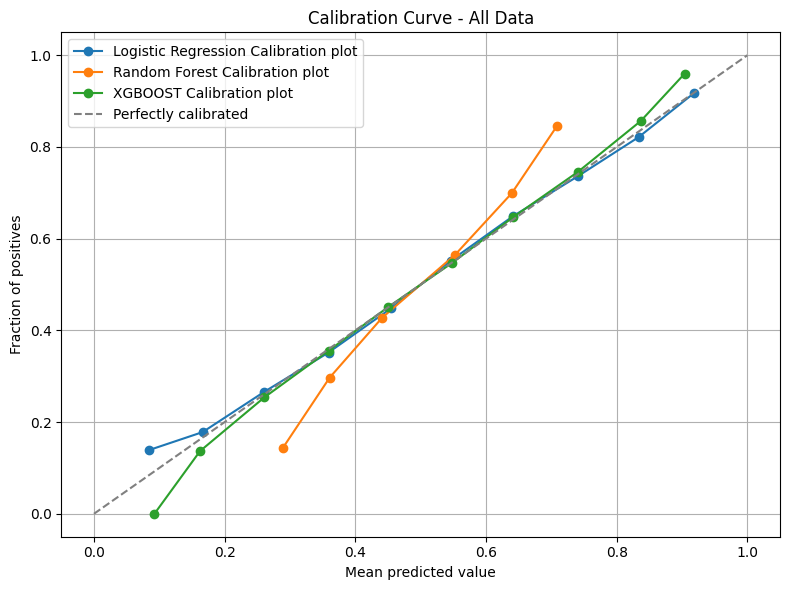

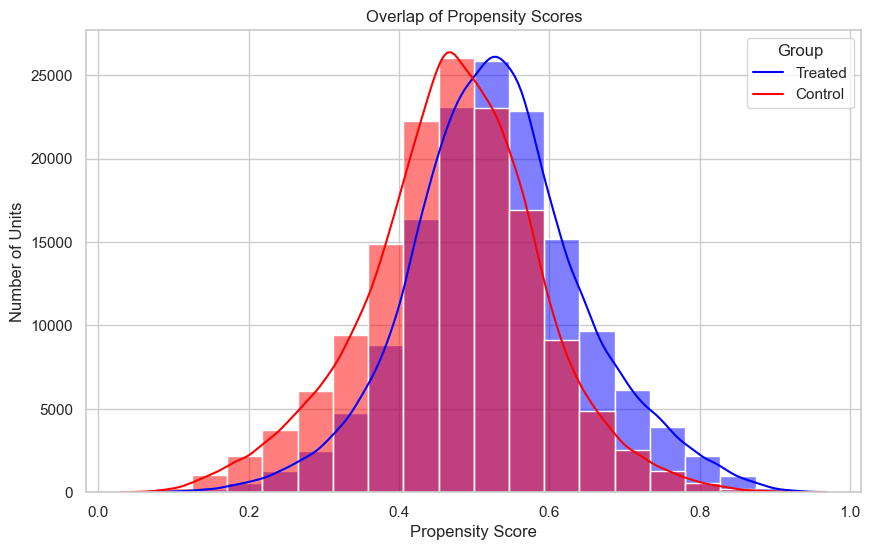

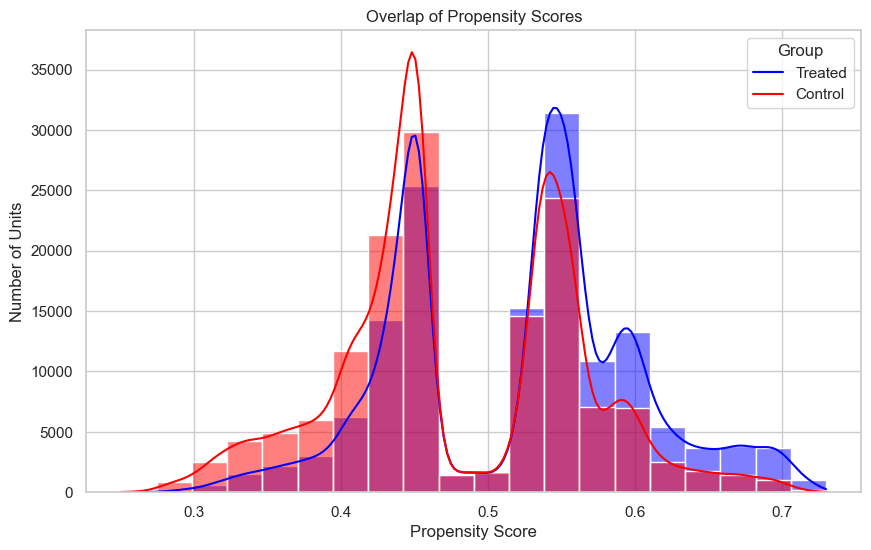

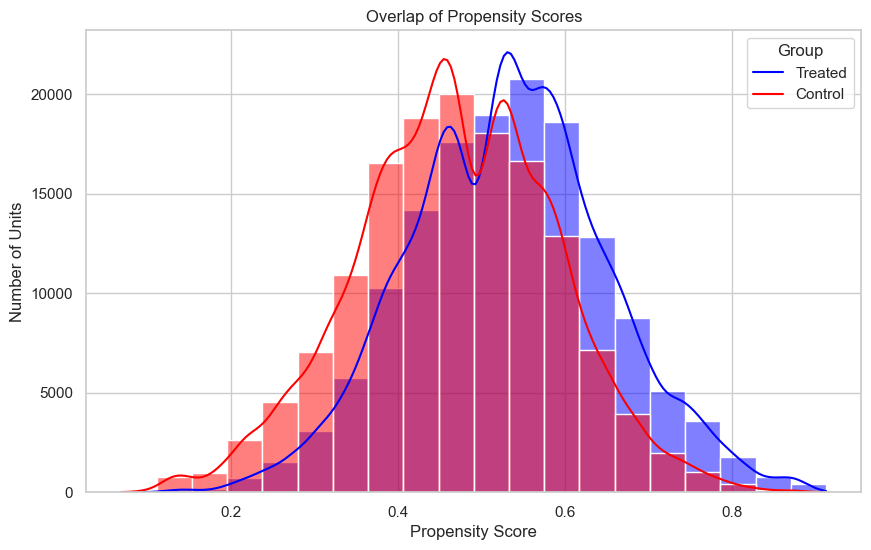

In [6]:
plot_calibration_curve(df['T'], {'Logistic Regression': propensity_score_lr,
                                 'Random Forest': propensity_score_rf,
                                 'XGBOOST': propensity_score_xgb})

plot_overlap(df['T'], propensity_score_lr)
plot_overlap(df['T'], propensity_score_rf)
plot_overlap(df['T'], propensity_score_xgb)

propensity_score = propensity_score_lr

# IPW

In [7]:
def IPW_ATE(df, propensity_score):
    n = len(df)
    y1 = df.loc[df['T'] == 1, 'Y']
    y0 = df.loc[df['T'] == 0, 'Y']

    assert n == len(y1) + len(y0), "Mismatch"

    ATT_ipw = (sum(y1 / propensity_score[df['T'] == 1]) - sum(y0 / (1 - propensity_score[df['T'] == 0]))) / n

    return ATT_ipw

#############################################################################
IPW_ATE_df = IPW_ATE(df, propensity_score)

ATE_df = pd.DataFrame({'Method': ['IPW'], 'ATE': [IPW_ATE_df]})
ATE_df

,Method,ATE
0,IPW,0.252258


# S-Learner

In [8]:
def SLearner_ATE(df, model):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['Y'])  
    y = df['Y']  .reset_index(drop=True)

    if type(model).__name__ in ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']:
      dummied_df = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
      X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df], axis=1)

    if type(model).__name__ in ['LogisticRegression']:
      scaler = MinMaxScaler()
      X_scaled = scaler.fit_transform(X)
      X = pd.DataFrame(X_scaled, columns=X.columns)

    if type(model).__name__ in ['CatBoostClassifier']:
        model.fit(X, y, cat_features=categorical_cols)
    else:
       model.fit(X, y)

    x1 = X.copy()
    x0 = X.copy()

    x1['T'], x0['T'] = 1, 0

    y1_pred = model.predict(x1)
    y0_pred = model.predict(x0)

    ATE = (y1_pred - y0_pred).mean()
    return ATE

#############################################################################
SLearner_ATE_df = SLearner_ATE(df, model=lr_model_class())

new_row = pd.DataFrame({'Method': ['S-learner'], 'ATE': [SLearner_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.252258
1,S-learner,0.815519


# T-Learner

In [9]:
def TLearner_ATE(df, model0, model1):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['Y'])
    y = df['Y'].reset_index(drop=True)

    if type(model1).__name__ in ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']:
      dummied_df_X = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
      X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df_X], axis=1)

    if type(model1).__name__ in ['LogisticRegression']:
      scaler = MinMaxScaler()
      X_scaled = scaler.fit_transform(X)
      X = pd.DataFrame(X_scaled, columns=X.columns)

    X1 = X[X['T']==1].drop(columns=['T'])
    y1 = y[X['T']==1].reset_index(drop=True)
    X0 = X[X['T']==0].drop(columns=['T'])
    y0 = y[X['T']==0].reset_index(drop=True)

    if type(model1).__name__ in ['CatBoostClassifier']:
        model1.fit(X1, y1, cat_features=categorical_cols)
        model0.fit(X0, y0, cat_features=categorical_cols)
    else:
       model1.fit(X1, y1)
       model0.fit(X0, y0)

    y1_pred = model1.predict(X.drop(columns=['T']))
    y0_pred = model0.predict(X.drop(columns=['T']))

    ATE = (y1_pred - y0_pred).mean()
    return ATE

#############################################################################
TLearner_ATE_df = TLearner_ATE(df, model0=lr_model_class(), model1=lr_model_class())

new_row = pd.DataFrame({'Method': ['T-learner'], 'ATE': [TLearner_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.252258
1,S-learner,0.815519
2,T-learner,0.809646


# Matching

In [10]:
def Matching_ATE(df):
    df_norm = df.copy()

    # Identify categorical and numerical columns
    categorical_cols = df_norm.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df_norm.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in ['Y', 'T']]

    # Normalize numerical columns
    scaler = MinMaxScaler()
    df_norm[numerical_cols] = scaler.fit_transform(df_norm[numerical_cols])

    # Separate into treated (T == 1) and control (T == 0) groups
    X1 = df_norm[df_norm['T'] == 1].reset_index(drop=True)
    X0 = df_norm[df_norm['T'] == 0].reset_index(drop=True)

    # Convert to NumPy arrays for faster computation
    X1_num = X1[numerical_cols].values
    X0_num = X0[numerical_cols].values

    X1_cat = X1[categorical_cols]
    X0_cat = X0[categorical_cols]

    # Calculate distances between all X1 and X0 instances
    distances = np.zeros((len(X1), len(X0)), dtype=np.int8)
    for i in range(len(X1)):
        num_dist = np.sum((X1_num[i] - X0_num)**2, axis=1)
        cat_dist = np.sum(X1_cat.iloc[i] != X0_cat, axis=1)
        distances[i, :] = np.sqrt(num_dist + cat_dist)

    # Find index of closest match in X0 for each X1 instance
    min_indices = np.argmin(distances, axis=1)

    # Calculate ATE for each treated instance
    ATE = X1['Y'].values - X0.loc[min_indices, 'Y'].values

    return ATE.mean()

#############################################################################
# Example usage assuming df is your DataFrame
matching_ATE = Matching_ATE(df)

new_row = pd.DataFrame({'Method': ['Matching'], 'ATE': [matching_ATE]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

MemoryError: Unable to allocate 19.5 GiB for an array with shape (144682, 144405) and data type int8

# Doubly - Robust

In [11]:
def DR_ATE(df, model0, model1, propensity_score):
    model_name = type(model1).__name__
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['Y'])
    y = df['Y'].reset_index(drop=True)

    if model_name in ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']:
      dummied_df_X = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
      X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df_X], axis=1)

    if model_name in ['LogisticRegression']:
      scaler = MinMaxScaler()
      X_scaled = scaler.fit_transform(X)
      X = pd.DataFrame(X_scaled, columns=X.columns)

    X1 = X[X['T']==1].drop(columns=['T'])
    y1 = y[X['T']==1]
    X0 = X[X['T']==0].drop(columns=['T'])
    y0 = y[X['T']==0]

    if model_name in ['CatBoostClassifier']:
        model1.fit(X1, y1, cat_features=categorical_cols)
        model0.fit(X0, y0, cat_features=categorical_cols)
    else:
       model1.fit(X1, y1)
       model0.fit(X0, y0)

    y1_pred = model1.predict(X.drop(columns=['T']))
    y0_pred = model0.predict(X.drop(columns=['T']))

    # ATE
    g1 = y1_pred + (df['T'].to_numpy() / propensity_score)*(y - y1_pred)
    g0 = y0_pred + ((1-df['T'].to_numpy()) / (1-propensity_score))*(y - y0_pred)
    return (g1 - g0).mean()

#############################################################################
DR_ATE_df = DR_ATE(df, model0=lr_model_class(), model1=lr_model_class(), propensity_score=propensity_score)

new_row = pd.DataFrame({'Method': ['Doubly Robust'], 'ATE': [DR_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.252258
1,S-learner,0.815519
2,T-learner,0.809646
3,Doubly Robust,0.255834


# CI

In [ ]:
def calc_bootstap_CI(df, method, propensity_score, model_class):
    ATEs = []
    for _ in range(300):
         sample_df = df.sample(n=len(df), replace=True) 
         if method == "IPW":
            result = IPW_ATE(sample_df, propensity_score)
         elif method == "S-learner":
           result = SLearner_ATE(sample_df, model_class())
         elif method == "T-learner":
           result = TLearner_ATE(sample_df, model_class(), model_class())
         elif method == "Matching":
           result = Matching_ATE(sample_df)
         elif method == "Doubly Robust":
           result = DR_ATE(sample_df, model_class(), model_class(), propensity_score)
         else:
           raise ValueError("Unknown method:", method)
         ATEs.append(result)

    lower_bound = round(np.percentile(ATEs, 2.5), 3)
    upper_bound = round(np.percentile(ATEs, 97.5), 3)
    return [lower_bound, upper_bound]

#############################################################################
ATE_df['CI'] = ATE_df['Method'].apply(lambda method: calc_bootstap_CI(df, method, propensity_score, lr_model_class))
ATE_df

In [ ]:
display(ATE_df)

In [11]:
# ate_path = 'ATE_results.csv'
# ATE_df.to_csv(ate_path, header=True, index=False)